In this notebook we study the tradeoff between
nat-err and rob-err
for SVMs on MNIST and CIFAR10.

## Set up libraries

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import thundersvm

import jax
import jax.numpy as jnp
from jax.interpreters import xla
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_platform_name", "cpu")

import neural_tangents as nt
from neural_tangents import stax

jnp.array([0]) # So warnings don't show up later
jax.local_devices()

[GpuDevice(id=0, task=0)]

In [3]:
import sys
sys.path.append("../..")

from adversarial_ntks import dataset, attacks, jthunder, kernel

## Load Data

In [4]:
%%time

MNIST_TRAIN = dataset.get_np_data(
    name="mnist", split="train", binary_labels=True)
MNIST_TEST = dataset.get_np_data(
    name="mnist", split="test", binary_labels=True)

CIFAR_TRAIN = dataset.get_np_data(
    name="cifar10", split="train", binary_labels=True)
CIFAR_TEST = dataset.get_np_data(
    name="cifar10", split="test", binary_labels=True)

print(MNIST_TRAIN.xs.shape)
print(MNIST_TEST.xs.shape)
print(CIFAR_TRAIN.xs.shape)
print(CIFAR_TEST.xs.shape)

(60000, 784)
(10000, 784)
(50000, 3072)
(10000, 3072)
CPU times: user 21.4 s, sys: 17.9 s, total: 39.3 s
Wall time: 6.68 s


[0 0 0 1 1 0 0 1 0 1]


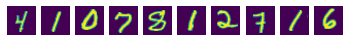

[0 0 0 1 1 1 0 1 0 0]


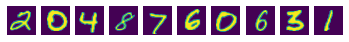

[1 1 0 0 1 1 0 1 1 1]


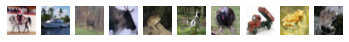

[1 0 1 1 1 0 1 0 0 0]


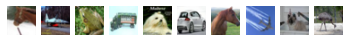

In [5]:
dataset.plot_images(MNIST_TRAIN, channels=1)
dataset.plot_images(MNIST_TEST, channels=1)
dataset.plot_images(CIFAR_TRAIN, channels=3)
dataset.plot_images(CIFAR_TEST, channels=3)

## Utility code

In [6]:
def ds_prefix(ds: dataset.Dataset, sz: int):
    return dataset.Dataset(xs=ds.xs[:sz], ys=ds.ys[:sz])

def avg_by_cls(xs, ys):
    return (xs[ys == 0].mean(), xs[ys == 1].mean())

def accs_by_cls(clf: thundersvm.SVC, ds: dataset.Dataset):
    return avg_by_cls(clf.predict(ds.xs) == ds.ys, ds.ys)

def fmt_accs(accs):
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

In [7]:
def eval_clf(
    clf: thundersvm.SVC,
    ds_train: dataset.Dataset,
    ds_test: dataset.Dataset,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    batch_size: int,
    verbose: bool = True,
    label: str = "",
):
    if verbose:
        print(f"{label}; n_support={clf.n_support_}; b={clf.intercept_[0]:.3e}; gam={clf._gamma:.3e}; coef0={clf.coef0}")
    
    accs_train = accs_by_cls(clf=clf, ds=ds_train)
    accs_test = accs_by_cls(clf=clf, ds=ds_test)
    if verbose:
        print(f"{label}; accs_train={fmt_accs(accs_train)}; accs_test={fmt_accs(accs_test)}")
    
    clf_grad_fn = jthunder.get_grad_decision_function(clf)
    
    xs_train_pgd = attacks.pgd(
        X=ds_train.xs, Y=ds_train.ys,
        grad_func=clf_grad_fn,
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=True,
        batch_size=batch_size,
    )
    xs_test_pgd = attacks.pgd(
        X=ds_test.xs, Y=ds_test.ys,
        grad_func=clf_grad_fn,
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=True,
        batch_size=batch_size,
    )
    
    accs_train_pgd = accs_by_cls(clf=clf, ds=dataset.Dataset(xs=xs_train_pgd, ys=ds_train.ys))
    accs_test_pgd = accs_by_cls(clf=clf, ds=dataset.Dataset(xs=xs_test_pgd, ys=ds_test.ys))
    if verbose:
        print(f"{label}; accs_train_pgd={fmt_accs(accs_train_pgd)}; accs_test_pgd={fmt_accs(accs_test_pgd)}")

    train_margins = jthunder.decision_function(clf, ds_train.xs) * (2 * ds_train.ys - 1)
    test_margins = jthunder.decision_function(clf, ds_test.xs) * (2 * ds_test.ys - 1)
    train_grad_norms = jnp.linalg.norm(
        clf_grad_fn(ds_train.xs),
        axis=-1, ord=2
    )
    test_grad_norms = jnp.linalg.norm(
        clf_grad_fn(ds_test.xs),
        axis=-1, ord=2
    )
    
    accs_train_linadv = avg_by_cls(train_grad_norms * attack_eps <= train_margins, ds_train.ys)
    accs_test_linadv = avg_by_cls(test_grad_norms * attack_eps <= test_margins, ds_test.ys)
    if verbose:
        print(f"{label}; accs_train_linadv={fmt_accs(accs_train_linadv)}; accs_test_linadv={fmt_accs(accs_test_linadv)}")
    
        
    return dict(
        accs_train=accs_train,
        accs_test=accs_test,
        attack_eps=attack_eps,
        accs_train_pgd=accs_train_pgd,
        accs_test_pgd=accs_test_pgd,
        xs_train_pgd=xs_train_pgd[:batch_size],
        xs_test_pgd=xs_test_pgd[:batch_size],
        accs_train_linadv=accs_train_linadv,
        accs_test_linadv=accs_test_linadv,
        train_margins=train_margins,
        test_margins=test_margins,
        train_grad_norms=train_grad_norms,
        test_grad_norms=test_grad_norms,
        train_ys=ds_train.ys.copy(),
        test_ys=ds_test.ys.copy(),
    )

# Begin experiments

In [8]:
RESULTS = {}

### Linear kernel
The code here memory leaks unfortunately :(

In [9]:
%%time
CUR_KEY = "svm-linear"
RESULTS[CUR_KEY] = []
print(f"Running {CUR_KEY}...")

for c in [1e-6, 2e-6, 4e-6, 8e-6, 1e-5, 2e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    clf = thundersvm.SVC(kernel="linear", C=c)
    clf.fit(MNIST_TRAIN.xs, MNIST_TRAIN.ys)
    
    res_dict = dict(c=c) #clf=clf) # storing clf can get expensive
    res_dict.update(
        eval_clf(
            clf=clf,
            ds_train=ds_prefix(MNIST_TRAIN, 512),
            ds_test=ds_prefix(MNIST_TEST, 512),
            label=f"C={c}",
            attack_eps=2.0,
            pgd_step_size=2.0/10,
            pgd_num_steps=20,
            batch_size=512,
        )
    )
    
    RESULTS[CUR_KEY].append(res_dict)

Running svm-linear...
C=1e-06; n_support=[29404 29404]; b=8.921e-01; gam=1.276e-03; coef0=0.0
C=1e-06; accs_train=(0.0000, 1.0000); accs_test=(0.0000, 1.0000)
C=1e-06; accs_train_pgd=(0.0000, 1.0000); accs_test_pgd=(0.0000, 1.0000)
C=1e-06; accs_train_linadv=(0.0000, 1.0000); accs_test_linadv=(0.0000, 1.0000)
C=2e-06; n_support=[29404 29404]; b=7.844e-01; gam=1.276e-03; coef0=0.0
C=2e-06; accs_train=(0.0000, 1.0000); accs_test=(0.0000, 1.0000)
C=2e-06; accs_train_pgd=(0.0000, 1.0000); accs_test_pgd=(0.0000, 1.0000)
C=2e-06; accs_train_linadv=(0.0000, 1.0000); accs_test_linadv=(0.0000, 1.0000)
C=4e-06; n_support=[29404 29404]; b=5.695e-01; gam=1.276e-03; coef0=0.0
C=4e-06; accs_train=(0.0041, 1.0000); accs_test=(0.0041, 1.0000)
C=4e-06; accs_train_pgd=(0.0000, 1.0000); accs_test_pgd=(0.0000, 1.0000)
C=4e-06; accs_train_linadv=(0.0000, 0.9888); accs_test_linadv=(0.0000, 0.9850)
C=8e-06; n_support=[28286 28286]; b=-4.141e-01; gam=1.276e-03; coef0=0.0
C=8e-06; accs_train=(0.7673, 0.7453); 

Natural
[0 0 0 1 1 1 0 1 0 0]


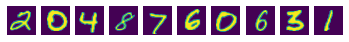


Adversarial
[0 0 0 1 1 1 0 1 0 0]


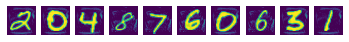

In [12]:
print("Natural")
dataset.plot_images(MNIST_TEST, channels=1)
print()
print("Adversarial")
dataset.plot_images(
    dataset.Dataset(xs=RESULTS["svm-linear"][-1]["xs_test_pgd"], ys=MNIST_TEST.ys),
    channels=1
)

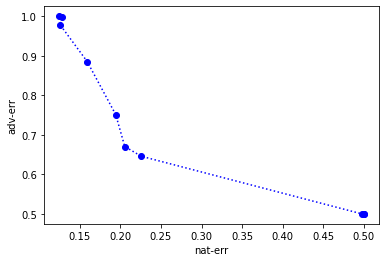

In [13]:
acc_tests = []
acc_tests_pgd = []
for res_dict in RESULTS["svm-linear"]:
    acc_tests.append(sum(res_dict["accs_test"]) / 2.0)
    acc_tests_pgd.append(sum(res_dict["accs_test_pgd"]) / 2.0)

acc_tests = np.array(acc_tests)
acc_tests_pgd = np.array(acc_tests_pgd)

plt.plot(1 - acc_tests, 1 - acc_tests_pgd, 'bo:')
plt.xlabel("nat-err");
plt.ylabel("adv-err");

We have a tradeoff between robustness and accuracy here!

Hypothesis: This is due to mismatch between linear model and dataset
which cannot be linearly separated in a robust fashion.

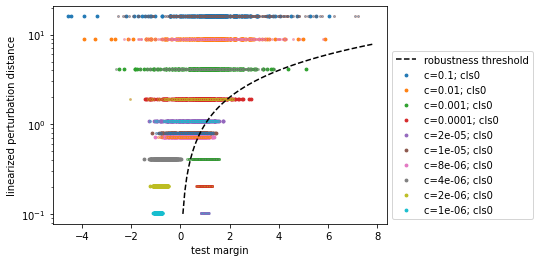

In [15]:
for i, res_dict in enumerate(reversed(RESULTS["svm-linear"])):
    plt.scatter(
        x=res_dict["test_margins"][res_dict["test_ys"] == 0],
        y=2.0 * res_dict["test_grad_norms"][res_dict["test_ys"] == 0],
        s=8, alpha=1, label=f"c={res_dict['c']}; cls0",
        color=f"C{i}"
    )
    plt.scatter(
        x=res_dict["test_margins"][res_dict["test_ys"] == 1],
        y=2.0 * res_dict["test_grad_norms"][res_dict["test_ys"] == 1],
        s=4, alpha=0.5, facecolors=None,
        edgecolors=f"C{i+5}"
    )
    
plt.plot(
    np.linspace(0.1, plt.xlim()[1], 100),
    np.linspace(0.1, plt.xlim()[1], 100),
    '--', color="black",
    label="robustness threshold"
)
    
plt.yscale("log")
plt.xlabel("test margin");
plt.ylabel("linearized perturbation distance");
plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1);

## RBF kernel

In [16]:
%%time
CUR_KEY = "svm-rbf"
RESULTS[CUR_KEY] = []  
print(f"Running {CUR_KEY}...")

for c in [1e-3, 2e-3, 4e-3, 8e-3, 1e-2, 1e-1, 1, 10, 100]:
    clf = thundersvm.SVC(kernel="rbf", C=c)
    clf.fit(MNIST_TRAIN.xs, MNIST_TRAIN.ys)
    
    res_dict = dict(c=c) #clf=clf) # storing clf can get expensive
    res_dict.update(
        eval_clf(
            clf=clf,
            ds_train=ds_prefix(MNIST_TRAIN, 512),
            ds_test=ds_prefix(MNIST_TEST, 512),
            label=f"C={c}",
            attack_eps=2.0,
            pgd_step_size=2.0/10,
            pgd_num_steps=20,
            batch_size=512,
        )
    )
    
    RESULTS[CUR_KEY].append(res_dict)

Running svm-rbf...
C=0.001; n_support=[29404 29404]; b=7.540e-01; gam=1.276e-03; coef0=0.0
C=0.001; accs_train=(0.0000, 1.0000); accs_test=(0.0000, 1.0000)
C=0.001; accs_train_pgd=(0.0000, 1.0000); accs_test_pgd=(0.0000, 1.0000)
C=0.001; accs_train_linadv=(0.0000, 1.0000); accs_test_linadv=(0.0000, 1.0000)
C=0.002; n_support=[29404 29404]; b=5.086e-01; gam=1.276e-03; coef0=0.0
C=0.002; accs_train=(0.0367, 1.0000); accs_test=(0.0325, 1.0000)
C=0.002; accs_train_pgd=(0.0000, 0.9813); accs_test_pgd=(0.0000, 0.9850)
C=0.002; accs_train_linadv=(0.0000, 0.9401); accs_test_linadv=(0.0000, 0.9624)
C=0.004; n_support=[27822 27822]; b=3.801e-01; gam=1.276e-03; coef0=0.0
C=0.004; accs_train=(0.3224, 0.9925); accs_test=(0.3130, 0.9850)
C=0.004; accs_train_pgd=(0.0041, 0.8577); accs_test_pgd=(0.0000, 0.8835)
C=0.004; accs_train_linadv=(0.0041, 0.7715); accs_test_linadv=(0.0000, 0.7970)
C=0.008; n_support=[24751 24751]; b=-4.263e-01; gam=1.276e-03; coef0=0.0
C=0.008; accs_train=(0.7673, 0.8240); acc

Natural
[0 0 0 1 1 1 0 1 0 0]


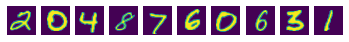


Adversarial
[0 0 0 1 1 1 0 1 0 0]


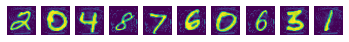

In [20]:
print("Natural")
dataset.plot_images(MNIST_TEST, channels=1)
print()
print("Adversarial")
dataset.plot_images(
    dataset.Dataset(xs=RESULTS["svm-rbf"][-1]["xs_test_pgd"], ys=MNIST_TEST.ys),
    channels=1
)

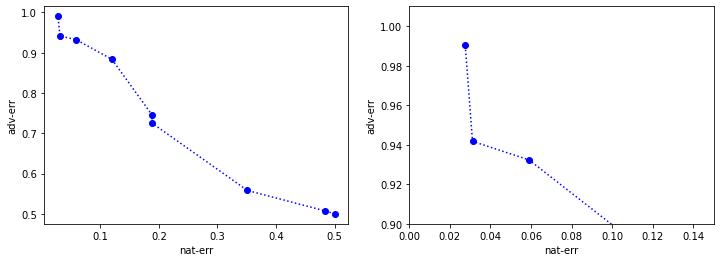

In [21]:
def main_plot():
    acc_tests = []
    acc_tests_pgd = []
    for res_dict in RESULTS["svm-rbf"]:
        acc_tests.append(sum(res_dict["accs_test"]) / 2.0)
        acc_tests_pgd.append(sum(res_dict["accs_test_pgd"]) / 2.0)

    acc_tests = np.array(acc_tests)
    acc_tests_pgd = np.array(acc_tests_pgd)

    plt.plot(1 - acc_tests, 1 - acc_tests_pgd, 'bo:')
    plt.xlabel("nat-err");
    plt.ylabel("adv-err");

plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)
main_plot()

plt.subplot(1, 2, 2)
main_plot()
plt.xlim(0, 0.15);
plt.ylim(0.9, 1.01);

Tradeoff between nat-err and adv-err also seen for the rbf kernel.

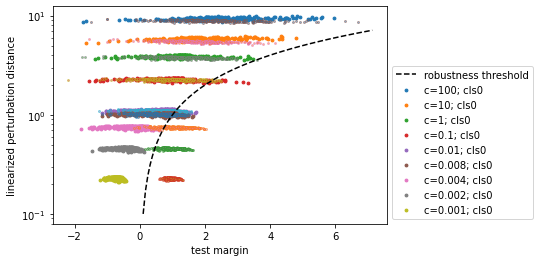

In [22]:
for i, res_dict in enumerate(reversed(RESULTS["svm-rbf"])):
    plt.scatter(
        x=res_dict["test_margins"][res_dict["test_ys"] == 0],
        y=2.0 * res_dict["test_grad_norms"][res_dict["test_ys"] == 0],
        s=8, alpha=1, label=f"c={res_dict['c']}; cls0",
        color=f"C{i}"
    )
    plt.scatter(
        x=res_dict["test_margins"][res_dict["test_ys"] == 1],
        y=2.0 * res_dict["test_grad_norms"][res_dict["test_ys"] == 1],
        s=4, alpha=0.5, facecolors=None,
        edgecolors=f"C{i+5}"
    )
    
plt.plot(
    np.linspace(0.1, plt.xlim()[1], 100),
    np.linspace(0.1, plt.xlim()[1], 100),
    '--', color="black",
    label="robustness threshold"
)
    
plt.yscale("log")
plt.xlabel("test margin");
plt.ylabel("linearized perturbation distance");
plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1);